# Introduction
Branches in CPU instructions are often a major reason for performance hits as work done in parts of the CPU pipeline has to be discarded and the target instruction address of the branch has to be calculated and fetched. As modern pipelines get more complicated, the slow down caused by branches increases. There are many different ways to lessen the impact of branching, such as a branch delay slot, multiple instruction streams and branch prediction. 

In this practical, we focus on different branch prediction strategies by writing a branch predictor simulator to simulate the strategies over a series of execution traces from benchmark programs and calculate the prediction rates. The results are then presented and analysed to understand the effectiveness of different strategies on different types of programs. 

The following branch prediction strategies were simulated and analysed:
- Always taken
- Always not taken
- 2-bit predictor
- Correlating predictor
- Gshare
- Profiled approach

# Design and methodology

## Benchmark programs
It is important to have a set of benchmarks with varied behaviour to understand the differences in the different branch prediction strategies. Seven benchmarks were chosen to try and get varied behaviour. Three of the benchmarks are from [SciMark2.0](http://math.nist.gov/scimark2/index.html) which are numeric and scientific calculations. One benchmark is the simple `echo` command line program. The other benchmarks were written by myself to try and get different behaviours. The SciMark benchmarks are more complicated with many calculations while mine are simple and more isolated in the kind of operations being done. This gives a variance between programs to understand how well each prediction strategy performs in general and to isolate specific behaviour. All benchmark programs are written in C. Below is an overview of each benchmark:

| Benchmark | Description | Input |
|------|------|------|
| Echo | Command line `echo` program that prints to the console. | A string to print |
|   FFT  | Taken from SciMark, this benchmark performs a one-dimensional forward transform of N complex numbers with complex arithmetic, shuffling, non-constant memory references and trigonometric functions. | N complex numbers (must be a power of 2) and M cycles.|
| MonteCarlo | Taken from SciMark, this benchmark approximates the value of Pi with random numbers which adds an element of random number generation | N the number of random numbers to be used|
| SOR | Taken from SciMark, this benchmark works on an NxN grid with operations on looping through and accessing neighbours | N the size of the grid and M cycles |
| Loop | This is a very simple benchmarks which only prints "Hello" N times. | N number of times to print |
| Conditional | This benchmark goes through a recursive function with conditionals where the value passed is changed until it reaches the base case | I an integer value to be used |
| BubbleSort | This is the classic bubble sort algorithm. It is methodic in the way it loops through the array to sort it, but as the array is randomly generated, the conditional will vary. | N the size of the array |


## Execution traces
To get the execution traces, we use Intel's PIN tool. The traces generated from the tool contain an address for the branch and a 0 if the branch was not taken and a 1 if the branch was taken. This execution trace only gives the address and if the branch was taken or not and not any additional information about the branch such as if it was a conditional or unconditional branch. We cannot assume that branches with 100% always taken are unconditional as it may just happen to be true for that execution. Due to this limitation, we can only present and analyse results of prediction rate on all the branches rather than study in detail differences between conditional and unconditional branches.


## Simulator implementation
Here is a brief overview of the implementation of the simulator.

In [1]:
%run predictors.py

The `Branch` enum represents whether the branch was taken or not. An enum is used instead of 0 and 1 to make it clear and avoid mistakes and errors.


`Step` contains the address of the instruction and whether or not that branch was taken - stored in `self.address` and `self.branch` respectively. This is the representation of each step of the execution trace.

The `Predictor` is the abstract class that our branch prediction strategies will extend. There are a few common functions defined here:
- `predict_correct` function will take a step in the execution and return whether or not the predictor predicted correctly. The function also updates the predictor's strategy accordingly, for example updating the history bits.
- `translate_address` applies a mask to the given address to get the bottom portion of the address within the table size.
- `simulate` will take the entire execution trace and return the percentage of correct branches that the predictor predicted.


## Branch prediction strategies

### Always taken and Always not taken

Always taken and always not taken are the simplest strategies and do as their names suggest. No logic is required as they simply return the same prediction every time.

In [2]:
class AlwaysTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

In [3]:
class AlwaysNotTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

### Two-bit predictor

The two-bit predictor uses two bits as history bits. The prediction is based off the most significant bit of the counter. The history serves as an indicator as to the recent behaviour of the branch (i.e, if the branch was taken the last few times, it will likely be taken again so predict that it is taken). Having two bits allows for some leeway if the branch diverges briefly from its main direction. If the prediction is wrong twice, then the prediction changes as this could indicate the branch has changed its main direction.

![Two-bit predictor](imgs/TwoBitPredictor.jpg)

The two-bit predictor includes a branch history table for addresses to index into to take into account the local history of each branch. The lower bits of the branch address is chosen as an index rather than the higher bits because they are more likely to be different and therefore less likely to collide.

In [4]:
class TwoBitCounter():
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        self.history_bits = (0, 0)
        
    def predict_correct(self, step):
        prediction = self.prediction
        
        prediction_correct = prediction == step.branch
        self.update(prediction_correct)
        
        return prediction_correct
        
    def update(self, prediction_correct):
        self.update_bits(prediction_correct)
        
        if self.history_bits[0]:
            self.prediction = Branch.TAKEN
        else:
            self.prediction = Branch.NOT_TAKEN
            
    def update_bits(self, prediction_correct):
        prediction_value = self.prediction.value
        
        if (prediction_correct):
            self.history_bits = (prediction_value, prediction_value)
        else:
            last_bit = self.history_bits[1]
            self.history_bits = (last_bit, int(not prediction_value))

`TwoBitCounter` is the saturating counter that keeps track of the recent behaviour of the branch. To change a prediction, two consecutive misses have to be recorded. An important point to notice is that by default, the prediction is set to `Branch.NOT_TAKEN`. This is done deliberately because of the additional cost of computing the branch target address. It is less costly to continue the next instruction in sequence rather than assume and calculate the address of the taken branch.

The `TwoBitPredictor` fetches the corresponding two bit counter from its predictor table by indexing with the branch address. It can then predict based on the counter and update the counter afterwards with the actual direction the branch took.

### Correlating predictor

The correlating predictor lets us have multiple two-bit counters per branch. A history shift register will tell the predictor which counter to choose for each branch. This strategy takes into account the global history - the shift register - rather than just the local history of each branch. The global history exploits the behaviour that the direction of previous branches affect the direction of the current branch. Depending on the global history of the shift register, it indexes to different two-bit counters on the same branch where the counters represent the local history. Having more history bits means more counters to index to. This approach also lowers the chance of two addresses overwriting each other's counters when they collide. This is because the two addresses would have had to have the same global history and lower bits of their address to overwrite the same saturating counter. 

In [5]:
class CorrelatingCounter():
    def __init__(self, register_bits):
        self.two_bit_counters = [TwoBitCounter() for i in range(2 ** register_bits)]

    def prediction(self, shift_register):
        counter = self.two_bit_counters[shift_register]
        return counter.prediction
    
    def update(self, prediction_correct, shift_register):
        counter = self.two_bit_counters[shift_register]
        counter.update(prediction_correct)

The `CorrelatingCounter` must have 2<sup>n</sup> `TwoBitCounter`s where *n* is the number of bits in the shift register per address in its predictor table. To get a prediction, the shift register must be passed so we can fetch the corresponding two-bit counter in the list. 

The shift register is updated by bit shifting 1 to the right after every step. Then, if the branch was taken, add a 1 to the n<sup>th</sup> bit.

### Gshare

The Gshare predictor indexes by XORing the address and the shift register to index into the predictor table. It is a strategy proposed by McFarling to hash the global history (shift register) and branch address to gain more information than either alone. This approach has the same advantage of using the global history as part of the index to a saturating counter like the correlating predictor, but uses much less space as we do not have a second level indexing. The idea is that by XORing the address and history, it spreads collisions of addresses across the table space to minimise the damage from the collisions.

In [6]:
class GsharePredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        if register_bits > table_bits:
            register_bits = table_bits
        
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.get_inner_predictor(address)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return counter.predict_correct(step)
    
    def get_inner_predictor(self, address):
        index = address ^ self.shift_register
        return self.table[index]
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1

        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)
            
    def simulate(self, execution):
        self.__init__(self.table_bits, self.register_bits)
        return super().simulate(execution)

## Profiled approach <a id='profiled_approach'></a>

The idea behind the profiled approach is to classify the branches seen in the profile run as either always taken, always not taken or in the middle of the two. Branches that are taken with a high percentage such as over 95% will be classified as always taken and use the always taken predictor and likewise branches taken with a lower percentage (<5%) are classified as always not taken. This follows from the idea that different strategies are most suitable for different branch behaviours. 

The branches are classified into four classes:
1. Always taken (>95% branches taken)
2. Always not taken (<5% branches taken)
3. Weak always taken/not taken (10% either taken or not taken)
4. Mixed

For class 1 and 2, the appropriate always predictor is used. For class 3, a two bit counter is used and finally for the mixed class, a correlating predictor is used. This is so the prediction rate can be increased by having an appropriate prediction strategy based on the behaviour of the branches seen by the profile. The two bit counter is used for class 3 because it is more effective for branches that go mostly in the same direction, but can change direction if needed. The correlating predictor is used for class 4 as the mixed branching direction could mean there is relevant history affecting the direction of the branch. The disadvantage is the need for a "warming up" phase to populate the table and extra memory needed. A Gshare predictor could also be used here instead of the correlating predictor. The profiled approach also has as a limited number of table sizes just like the other predictors.

In [7]:
class ProfiledPredictor(Predictor):
    def __init__(self, table_bits, history_bits):
        counters = enumerate([TakenCount() for i in range(2 ** table_bits)])
        self.table = {address: count for address, count in counters}
        self.table_bits = table_bits
        
        self.mask = 2**table_bits - 1
        self.classifications = {}
        
        self.main_predictor = CorrelatingPredictor(table_bits, history_bits)
        self.history_bits = history_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        strategy = self.table[address]
        
        return strategy.predict_correct(step)
        
    def get_classifications(self):
        classifications = {}
        for address, count in self.table.items():
            if (count.total_count > 0):
                percentage_taken = count.taken_count/float(count.total_count)
                if percentage_taken > 0.95:
                    classifications[address] = AlwaysTakenPredictor()
                elif percentage_taken < 0.05:
                    classifications[address] = AlwaysNotTakenPredictor()
                elif percentage_taken > 0.9 or percentage_taken < 0.1:
                    classifications[address] = TwoBitCounter()
                else:
                    classifications[address] = self.main_predictor
                
        return classifications
    
    def simulate(self, execution):
        self.__init__(self.table_bits, self.history_bits)
        
        for step in execution: 
            address = int(step.address) & self.mask
            if (step.branch == Branch.TAKEN):
                self.table[address].taken_count += 1
            self.table[address].total_count += 1
        
        self.table = self.get_classifications()
        
        return super().simulate(execution)

The profiled approach is similar to that of a tournament predictor, where multiple strategies are considered. The difference is rather than running all the strategies to find the best one to use, the predictor strategy is chosen based on the classification from the profile. This would be more efficient in terms of the computation of the predictors as not all the predictors have to be run. However, some additional hardware may be needed to keep track of the branch classifications.

Additionally, a normal profiled approach would run closer to hardware and be done at run time rather than in hindsight profiling the execution trace. However, this still serves as a way to see in theory how a profiled approach would have better advantages over using a single strategy for prediction.

# Experiments and results

## Benchmark branch properties

First, an overview of the branch properties of our benchmarks programs. `benchmarks.py` will parse and load all benchmark traces.


In [8]:
%run benchmarks.py

`benchmark_properties` can be passed a trace and return the properties of the trace such as the number of unique branches and the total length of the trace. For example: 

In [9]:
trace_echo = parseTrace(open("traces/Echo.out", "r"))
print(benchmark_properties("Echo", trace_echo))

Echo
Total length: 48361
Unique branches: 2319
Percentage taken: 51.15692396765989


Below is a table which shows the branching properties of each benchmark. The three SciMark benchmarks `FFT`, `SOR` and `MonteCarlo` have a much higher percentage of branches taken compared to the other benchmarks. This is likely due to the lower amount of I/O and higher amount of calculations. We can see the `Loop` and `LoopCondition` programs, which output to console on every loop have a lower percentage of branches taken, similar to the `Echo` program which is also the shorter trace. `BubbleSort` sits in the middle between the two extremes. It has many comparisons and operations to sort the list, but also I/O at the end of the program to output the sorted list. 

| Program | Total branches | Number of unique branches | % of branches taken |
| ------ | ----- | ----- |
| Echo | 48361 | 2319 | 51.16|
| FFT | 273784 | 2303 | 82.11 |
| SOR | 369432 | 2171 | 87.84 |
| MonteCarlo | 321653 | 2134 | 81.91 |
| Loop | 451068 | 1922 | 58.47 |
| LoopCondition | 66006 | 1999 | 53.45 |
| BubbleSort | 369764 | 2050 | 68.90 |
<center> Properties of benchmark programs </center>

These properties also represent the result of an always taken/always not taken predictor. For the SciMark benchmarks, an always taken predictor seems like a valid strategy, but this is in hindsight, having calculated the percentage of branches taken and not a good strategy for a processor that needs to run a mix of different programs. However, this does show the power of being able to profile a program before running it. For example if we have profiled `SOR` and are happy to trade off some misprediction for the simplicity of always predicting taken, we do not have to power any other prediction hardware for power efficiency.

## Experiments

In [10]:
%run experiments.py
%matplotlib inline



For our initial experiments, we want to look at how each predictor performs against the benchmarks and see the kind of results and prediction rates we get. We first vary the address table size to see if it has an impact on performance. The larger the table size, the more addresses we can store and the less likely it would be for two addresses to collide and index into the same row of the table. Even though from our benchmark properties, we can see there is not more than 2500 unique addresses, having more table space is still important as some addresses could be very far from each other and have the same lower bits. Being able to index with more bits to lower the chance of this happening therefore should improve performance of all the predictors.

### Two bit predictor results

In [11]:
twobit_experiment = new_benchmark_experiment()

for i in range(1, 13):
    twobit_predictor = TwoBitPredictor(i)
    for k, v in twobit_experiment.items():
        v.data.append((len(twobit_predictor.table), twobit_predictor.simulate(v.trace)))

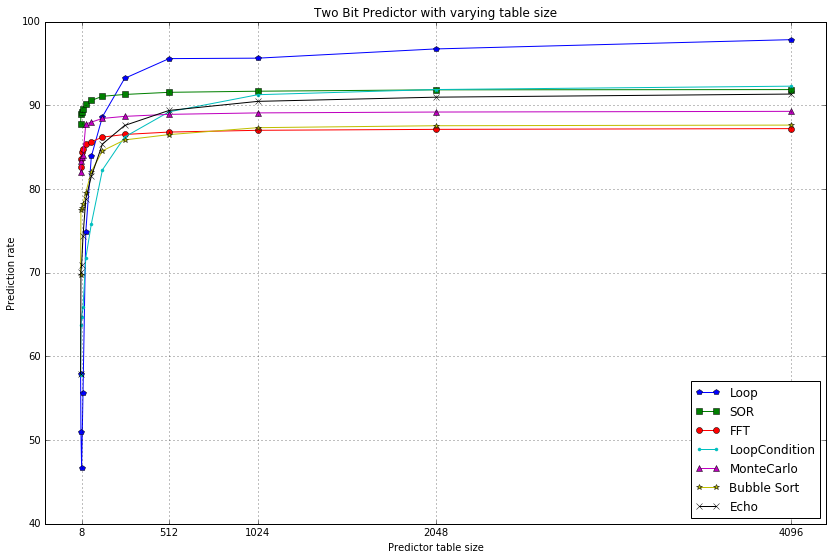

In [12]:
twobit_graph = plot_graph("Two Bit Predictor with varying table size", 
                          [data for _, data in twobit_experiment.items()])
twobit_graph.plot()
plt.show()

As the table size increases, the prediction rate of all the benchmarks increases. This behaviour is natural as more address space reduces the number of collisions. What is important to note is that the growth in prediction rate is not linear to the number of addresses. Moreover, the growth in prediction rate is reduced as the number of addresses increases. From this we can see that increasing address space gives diminishing returns and to achieve higher prediction rates, we may need a better prediction strategy.

Recall that the three SciMark programs have a high percentage of branches taken and are more calculation and operation heavy. The two bit predictor graph shows these three benchmarks starting with a high prediction rate and not gaining much as the table size increases. This contrasts with the high I/O benchmarks such as `Loop` and `LoopCondition`. 

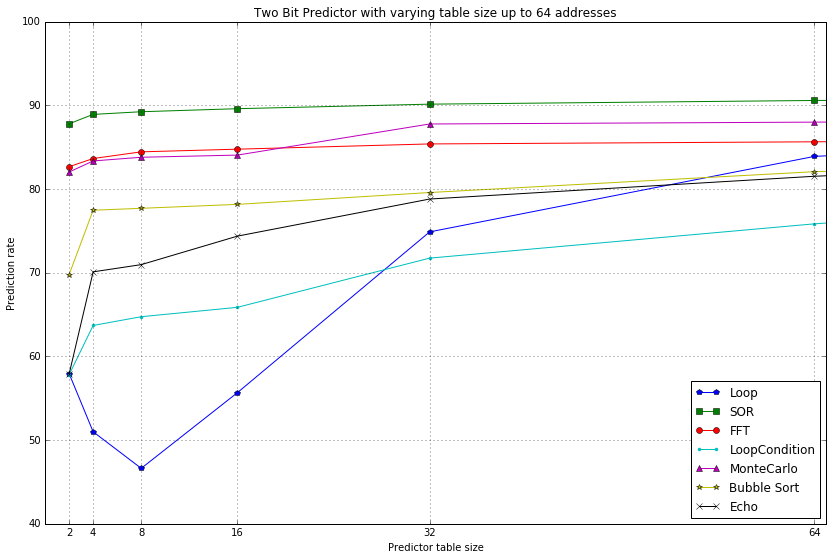

In [13]:
twobit_graph = plot_graph("Two Bit Predictor with varying table size up to 64 addresses", 
                          [data for _, data in twobit_experiment.items()], 
                          xticks=[2,4,8,16,32,64])
twobit_graph.plot()
plt.xlim(0,65)
plt.show()

The SciMark benchmarks start with a high prediction rate, even with only 2 or 4 entries in the predictor table. This may be related to their high percentage of branches taken (up to 87% for the `SOR` benchmark). Even with a small predictor table, if a large majority of branches follow the same pattern, performance is not greatly affected. This is also apparent as an increase in the table size does not lead to the same significant increase in prediction rate as the other benchmarks - less than 10% increase in prediction rate compared to over 30%.

The `Loop` benchmark has an odd graph as its prediction rate initially goes down. The performance then vastly increases as the table size increases. This suggests the number of entries in the predictor history table is initially not enough to contain all the branches of one iteration of the loop, causing the saturing counters to be overwritten, leading to the low prediction rate. At 4 and 8 spaces in the table, the way the branches are addressed may line up just right such that the collisions lead to very poor performance, for example if the same places in the loop are always being overwritten and predicted incorrectly. As the table size increases and address collisions decrease the problem is reduced until all branches of the loop can be stored concurrently in the history table. This can be seen from the high prediction rate achieved with a larger table size.

We can see that the two bit predictor works well with branches which mostly go in one direction and this is shown from the SciMark benchmarks and the `Loop` benchmark once it has enough table space. The second bit provides resistance to a temporary change in the direction of the branch, allowing the predictor to continue to retain the main direction of the branch. However the predictor performs poorly when there is not a clear direction that a branch is heading. This is seen from the `Loop` benchmark when the entire loop could not be stored in the predictor table and collisions happen frequently. The predictor could not accurately predict the direction of the branch due to the saturating counters being overwritten too often and therefore performed poorly.

### Correlating predictor results

We next look at the results for the correlating predictor, which takes into account the direction of other branches in the program for its prediction using the shift register.

In [14]:
cp_experiment_twobits_history = new_benchmark_experiment()

for i in range(1, 13):
    cp = CorrelatingPredictor(i, 2)
    for k, v in cp_experiment_twobits_history.items():
        v.data.append((len(cp.table), cp.simulate(v.trace)))

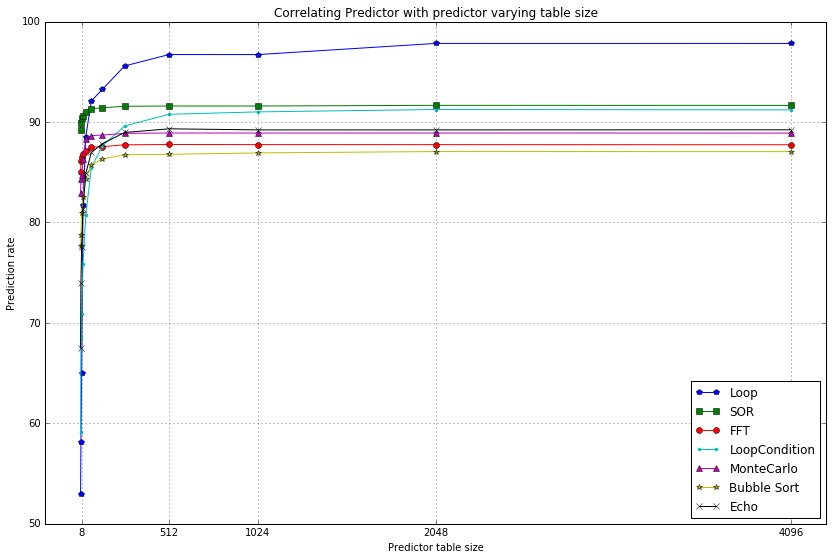

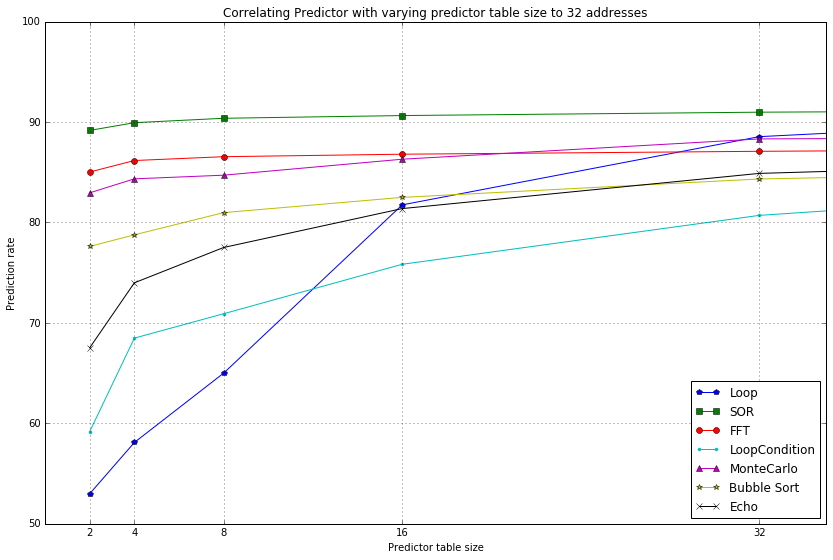

In [15]:
correlating_twobit_history_graph = plot_graph("Correlating Predictor with predictor varying table size", 
                                              [data for _, data in cp_experiment_twobits_history.items()])
correlating_twobit_history_graph.plot()
plt.show()

correlating_twobit_history_graph = plot_graph("Correlating Predictor with varying predictor table size to 32 addresses", 
                                              [data for _, data in cp_experiment_twobits_history.items()], 
                                              xticks=[2,4,8,16,32])
correlating_twobit_history_graph.plot()
plt.xlim(0, 35)
plt.show()

By taking the global history into account, the correlating predictor gets good performance even with low table entries. By indexing a second layer table with the global history, it reduces the effect of address collisions overwriting the saturating counters as the same address *and* history is required to overwrite the counter. As such, the issue of `Loop` having initial poor performance despite an increase in table size is not longer here. With a constant shift register size, the correlating predictor follows the same pattern of increased prediction rate with increased address space and diminishing returns. 

#### Correlating predictor with varied history bits
For correlating predictors which use a global history, the number of bits we use for the history (shift register) is an important factor to performance. The more bits used in the shift register, the more previous branches affect the current prediction. For example a shift register using 10 bits will use the history of the previous 10 branches to index into the predictor tables. Having more shift register bits may not always result in an increase in performance if looking too far back in the history becomes irrelevant to the branch we are currently trying to predict.

In [16]:
def correlating_experiment_history_bits(bits):
    experiment = new_benchmark_experiment()
    
    for i in range(1, 12):
        cp = CorrelatingPredictor(bits, i)
        for k, v in experiment.items():
            v.data.append((i, cp.simulate(v.trace)))

    return experiment
            
cp_experiment_64_addresses = correlating_experiment_history_bits(6)
cp_experiment_512_addresses = correlating_experiment_history_bits(9)
cp_experiment_1024_addresses = correlating_experiment_history_bits(10)
cp_experiment_2048_addresses = correlating_experiment_history_bits(11)

<function matplotlib.pyplot.show>

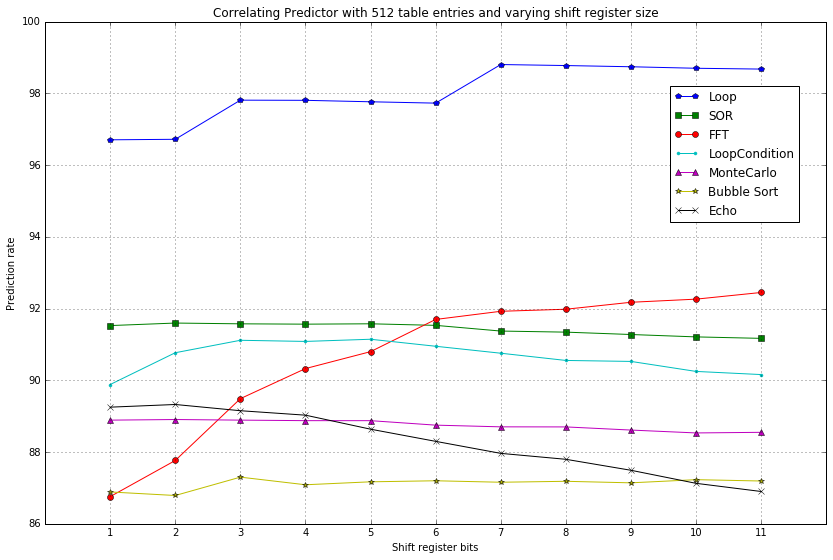

In [17]:
cp_512_addresses_graph = plot_graph("Correlating Predictor with 512 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_512_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
cp_512_addresses_graph.plot()
plt.legend(loc=(0.8,0.6))
plt.xlim(0, 12)
plt.show

With different benchmarks, the size of the register bits have a different effect. For `FFT` the performance continues to increase with the number of register bits, but other benchmarks such as `Echo` have continually lower performance with more register bits. 

`FFT` having increased performance suggests its inner loop makes use of more branches than the other benchmarks. Other benchmarks hit their peak performance earlier and start to lose performance with more register bits. For example `LoopCondition` gets good performance at 3 to 5 bits of history and `Echo` at 1 to 2 bits. When the number of history bits becomes too high, the global history overfits the repetitive sequence, causing the sequence patterns to overlap and hurt performance. 

In the case of the `Loop` benchmark, the performance increases in steps. This suggests the number of history bits is able to cover multiple inner loops or able to find some larger pattern of branches. After each step, the prediction rate will decrease slightly before the next step, most likely because the loop sequence does not entirely fit into the history or the pattern sequence that was matched is polluted from extra bits. Despite this, the prediction rate decrease is only minimal, showing how the correlating predictor is able to deal with these issues. The `FFT` performance increase is not in steps but more continuous, meaning the sequence pattern is probably yet to be properly matched with the number of history bits.

Because `Echo` has no loops and is a short execution trace, it has a sharper loss in performance with more history bits compared to other benchmarks as a longer history is irrelevant to the way its branches behave.

This shows us that for correlating predictors, the number of bits used in the shift register needed for good performance depends a lot on the behaviour of the program being run. A different number of history bits may work better for different branching behaviours and we can only fit the correlation between the prediction and previous history well if the behaviour is known beforehand. Having more history bits potentially allow detection of more sequences but it runs the risk of detecting overlapping sequences or irrelevant history that impacts performance. Increased history bits is also extremely costly in terms of memory. Every extra bit added to the shift register doubles the number of saturating counters in the predictor. For example a correlating predictor with 512 addresses needs 512 \* 2<sup>2</sup> = 2048 saturating counters for a 2 bit shift register. A 3 bit shift register would require 512 \* 2<sup>3</sup> = 4096 saturating counters.

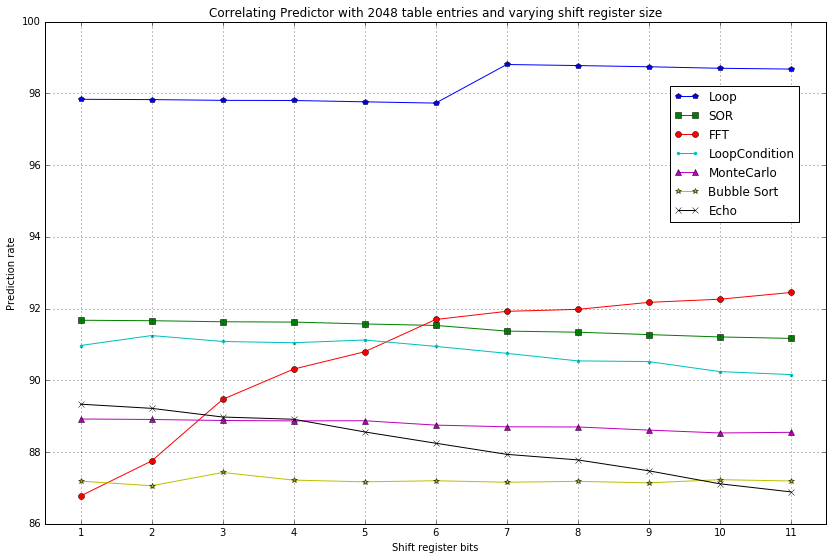

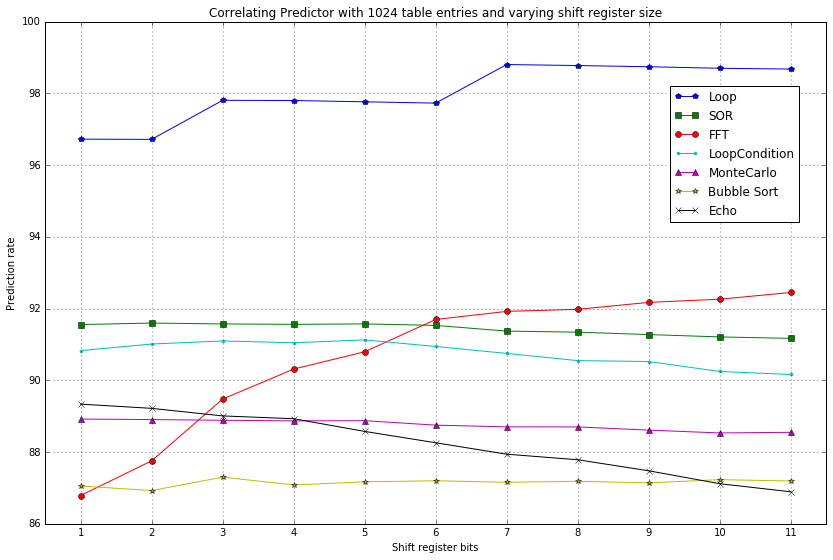

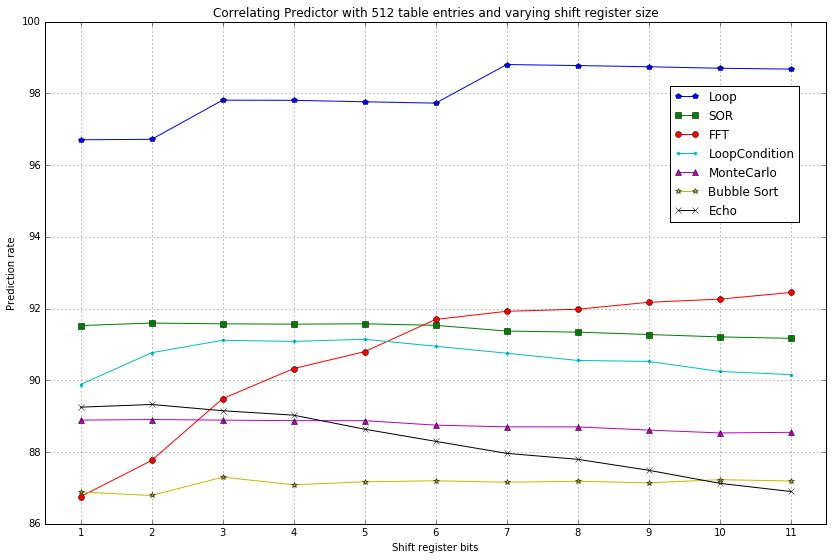

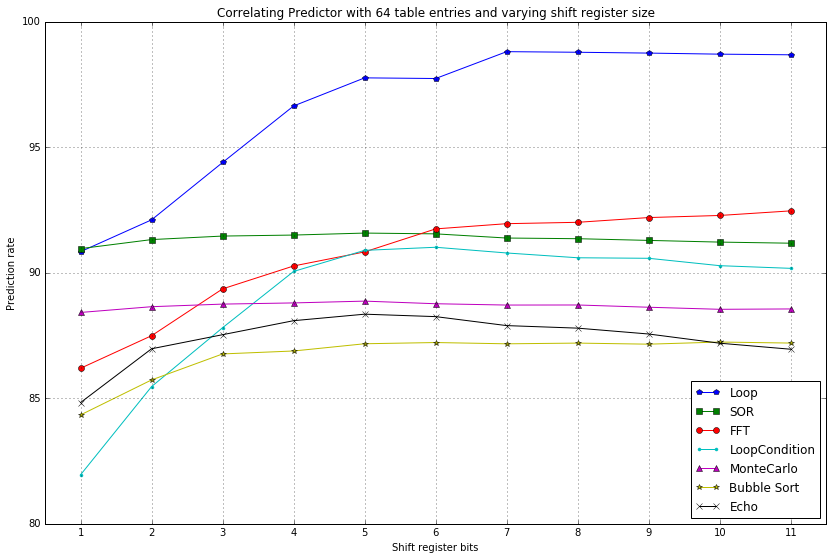

In [18]:
cp_64_addresses_graph = plot_graph("Correlating Predictor with 64 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_64_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="lower right")
cp_512_addresses_graph = plot_graph("Correlating Predictor with 512 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_512_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(0.8,0.6))
cp_1024_addresses_graph = plot_graph("Correlating Predictor with 1024 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_1024_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(0.8,0.6))
cp_2048_addresses_graph = plot_graph("Correlating Predictor with 2048 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_2048_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(0.8,0.6))

cp_64_addresses_graph.plot()
cp_512_addresses_graph.plot()
cp_1024_addresses_graph.plot()
cp_2048_addresses_graph.plot()

plt.show()

It is interesting to see the combined effect of the predictor table size and number of history bits. We have already seen that increased table size leads to increased prediction rate and argued why increasing the number of history bits may not always be beneficial, so we want to see how these parameters work in tandem.

The number of predictor table addresses affects the shape of the graphs with varying shift register bits only when collisions are an issue. At a low address table size and low shift register size, the performance is dominated by the address table size and the history bits serves more to reduce the impact of collisions rather than correlate and predict the next branch based on the previous branches. However, as the history bits increase, the effect of the address table size decreases. At 11 history bits, the prediction rates of each benchmark are very similar regardless of the size of the address table. 

### Gshare predictor results

Gshare also aims to use the global history of other branches for its prediction, but does so without the need for 2<sup>n</sup> extra counters by XORing the global history with the branch address as its index.

In [19]:
gshare_experiment_twobits_history = new_benchmark_experiment()

for i in range(2, 13):
    gp = GsharePredictor(i, 2)
    for k, v in gshare_experiment_twobits_history.items():
        v.data.append((len(gp.table), gp.simulate(v.trace)))

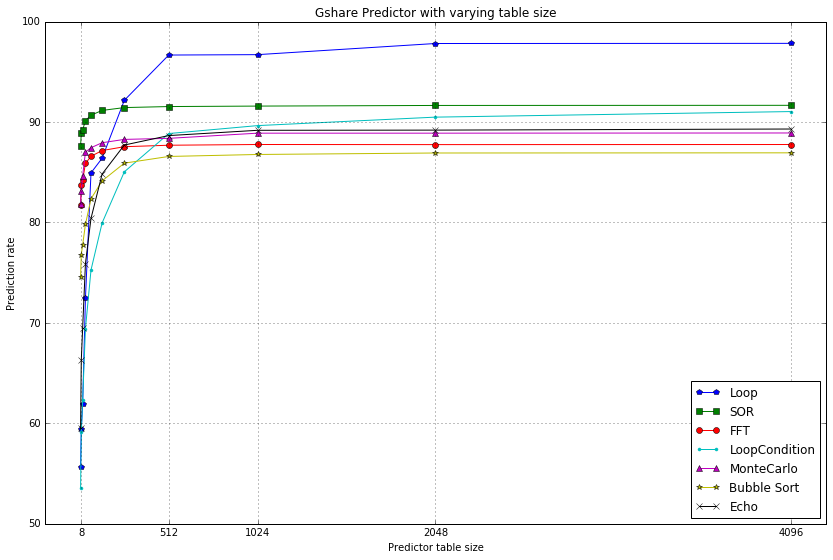

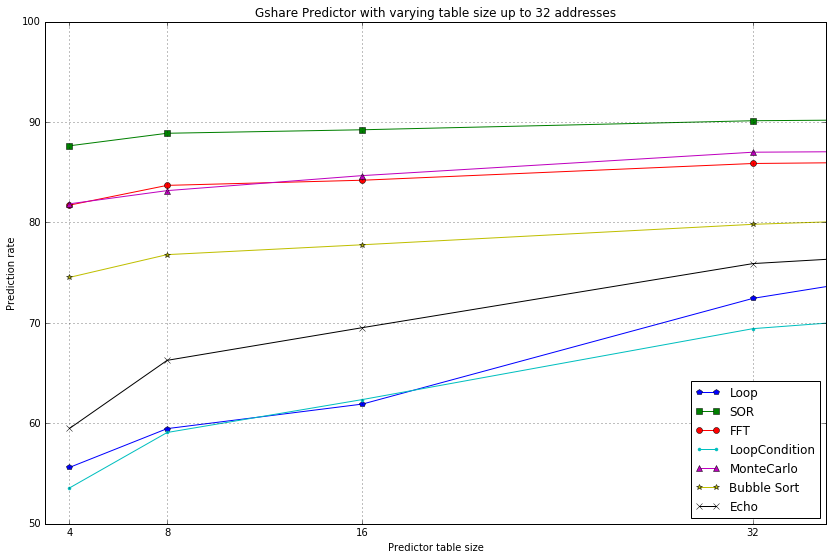

In [20]:
gshare_twobit_history_graph = plot_graph("Gshare Predictor with varying table size", 
                                         [data for _, data in gshare_experiment_twobits_history.items()])
gshare_twobit_history_graph.plot()
plt.show()
gshare_twobit_history_graph = plot_graph("Gshare Predictor with varying table size up to 32 addresses", 
                                         [data for _, data in gshare_experiment_twobits_history.items()], 
                                         xticks=[2,4,8,16,32])
gshare_twobit_history_graph.plot()
plt.xlim(3, 35)
plt.show()

When keeping the shift register size the same, the result of changing the table size follows the same patterns as we have seen in the two bit predictor and correlating predictor. The prediction rate increases with the table size with diminishing returns and again the SciMark benchmarks begin with higher prediction rate likely to do with their property of high percentage of branches taken.

What is more interesting is the number of history bits of how they change the performance of Gshare.

#### Gshare with varying shift register size

For Gshare, there is no reason to have more shift register bits than bits in the predictor address table. For example if there are 512 (2<sup>9</sup>) addresses, XORing using 10 bits of history is no different from XORing using 9 bits of history since only the last 9 bits are used as the index into the table. As such, the length of the address table is directly related to the effectiveness of the history bits in this scheme, as opposed to in the correlating predictor.

In [21]:
def gshare_history_experiment(bits):
    experiment = new_benchmark_experiment()
    
    for i in range(1, bits + 1):
        gp = GsharePredictor(bits, i)
        for k, v in experiment.items():
            v.data.append((i, gp.simulate(v.trace)))
            
    return experiment
            
gp_experiment_64_addresses = gshare_history_experiment(6)
gp_experiment_512_addresses = gshare_history_experiment(9)
gp_experiment_1024_addresses = gshare_history_experiment(10)
gp_experiment_2048_addresses = gshare_history_experiment(11)

<function matplotlib.pyplot.show>

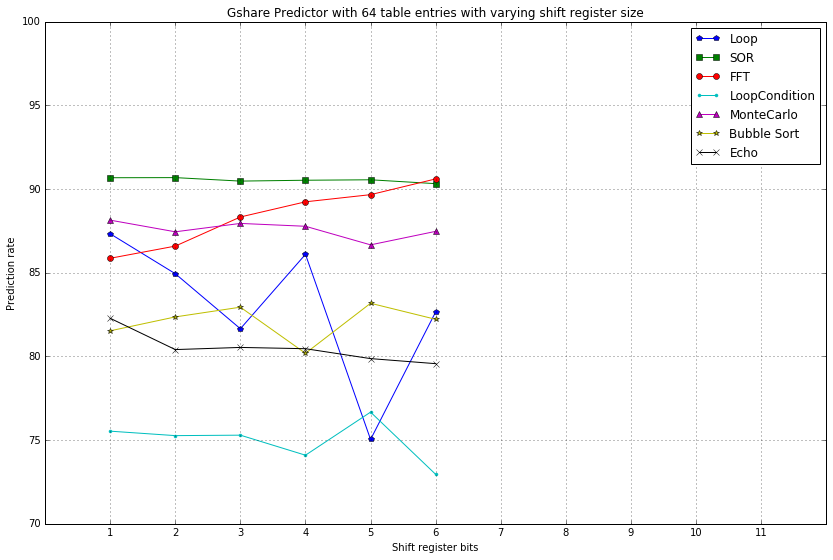

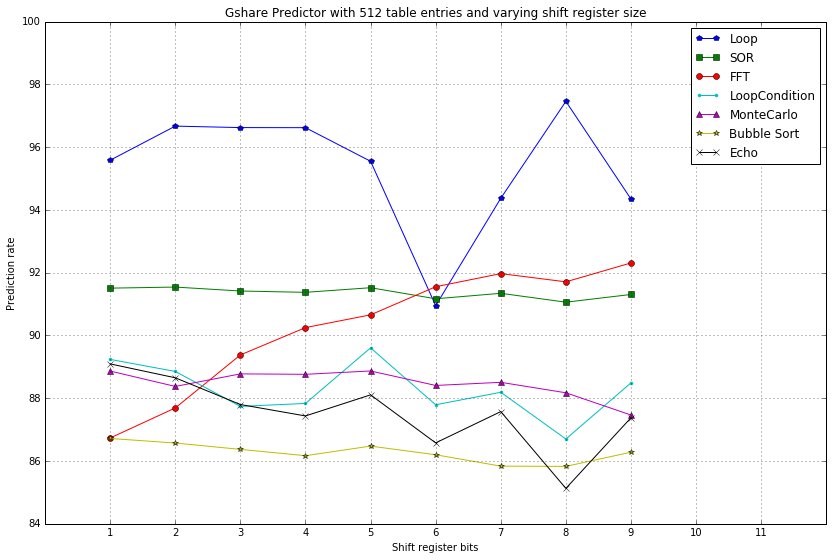

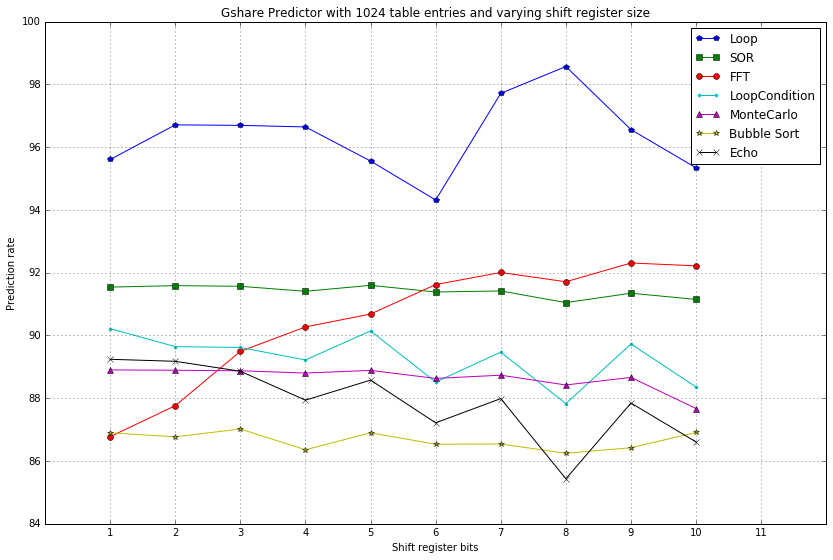

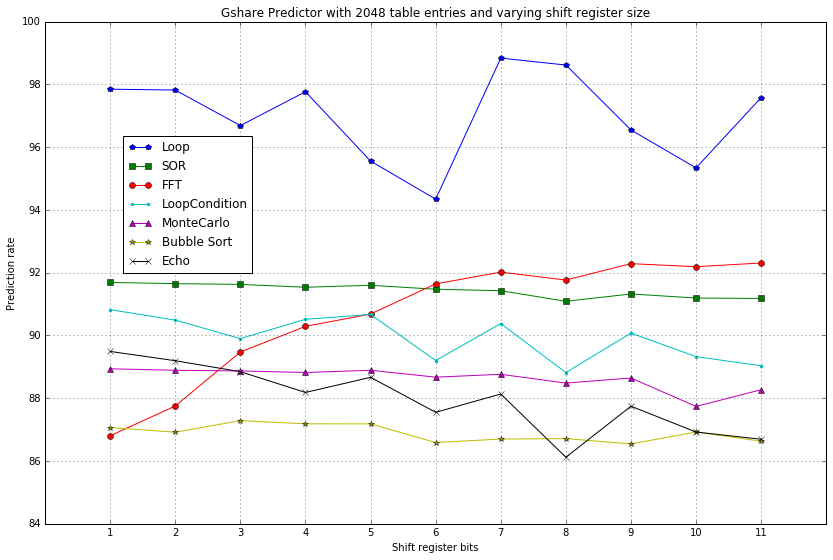

In [22]:
gp_64_addresses_graph = plot_graph("Gshare Predictor with 64 table entries with varying shift register size",
                                   [data for _, data in gp_experiment_64_addresses.items()],
                                   xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="best")
plt.xlim(0, 12)
gp_512_addresses_graph = plot_graph("Gshare Predictor with 512 table entries and varying shift register size", 
                                    [data for _, data in gp_experiment_512_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="best")
plt.xlim(0, 12)
gp_1024_addresses_graph = plot_graph("Gshare Predictor with 1024 table entries and varying shift register size", 
                                    [data for _, data in gp_experiment_1024_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="upper right")
plt.xlim(0, 12)
gp_2048_addresses_graph = plot_graph("Gshare Predictor with 2048 table entries and varying shift register size", 
                                    [data for _, data in gp_experiment_2048_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(0.1, 0.5))
plt.ylim(84, 100)
plt.xlim(0, 12)
gp_64_addresses_graph.plot()
gp_512_addresses_graph.plot()
gp_1024_addresses_graph.plot()
gp_2048_addresses_graph.plot()
plt.xlim(0, 12)
plt.show

Similar to the correlating predictor, the decision on an optimal number of bits to use in the shift register depends on the behaviour of programs being run and the number of branches that create a sequence pattern for the predictor to recognise.

Some benchmarks like `FFT` continue to exhibit a similar trend to the correlating predictor, where the prediction rate continues to go up with more register bits. However, for other benchmarks like `Loop` and `Echo`, the trend is more irregular. 

The very interesting case is the `Loop` benchmark, especially for the graph of 512 and 64 addresses, there is a point at 6 and 5 history bits respectively where the performance drops before climbing back up higher than before and dropping again. This trend is odd, but not the only case as `Echo` and `LoopCondition` also have similar but not as extreme behaviour. This likely shows the cost of having mis-aligned sequences of branches causing a lot of collisions and mispredictions. The drop in performance is not as sharp when comparing to a table size of 2048 or 1024 which leads me to believe it is a collision issue. Again this depends on the benchmark and may be due to I/O. The three benchmarks with jagged trendlines are benchmarks with significantly more I/O than the others and also have the lowest percentage of total branches taken. The SciMark benchmarks on the other hand are more stable.

This shows that Gshare is more vulnerable to penalties from irrelevant history and collisions if there is not enough address space. The XOR tries to mitigate collisions by spreading out the index across the address space, but this causes more harm with small address spaces as it could overwrite other locations which contain useful or important counters. This damage is amplified as the overwriting is spread out across all addresses, rather than just colliding and overwriting in one location. The advantage of Gshare is being able to use global history without the increased memory cost of the correlating predictor.

### Profiled approach results

In [23]:
pp_experiment = new_benchmark_experiment()

for i in range(1, 13):
    pp = ProfiledPredictor(i, 2)
    for k, v in pp_experiment.items():
        v.data.append((len(pp.table), pp.simulate(v.trace)))

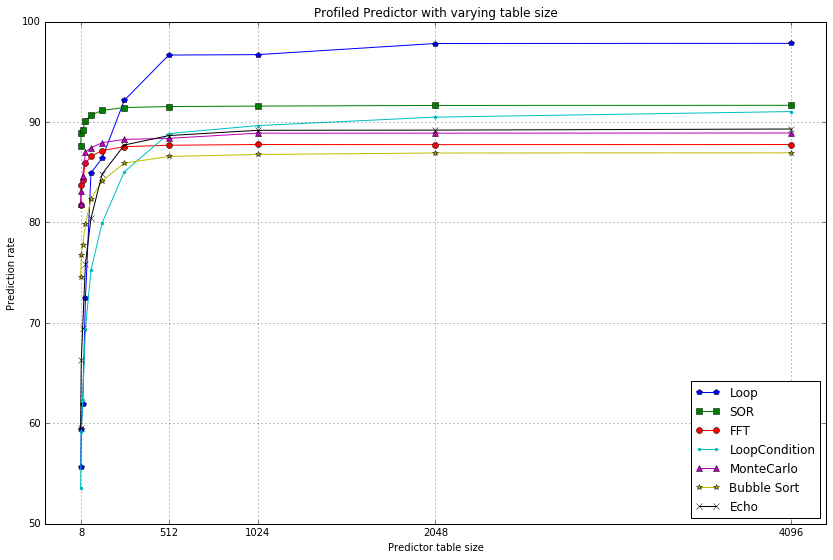

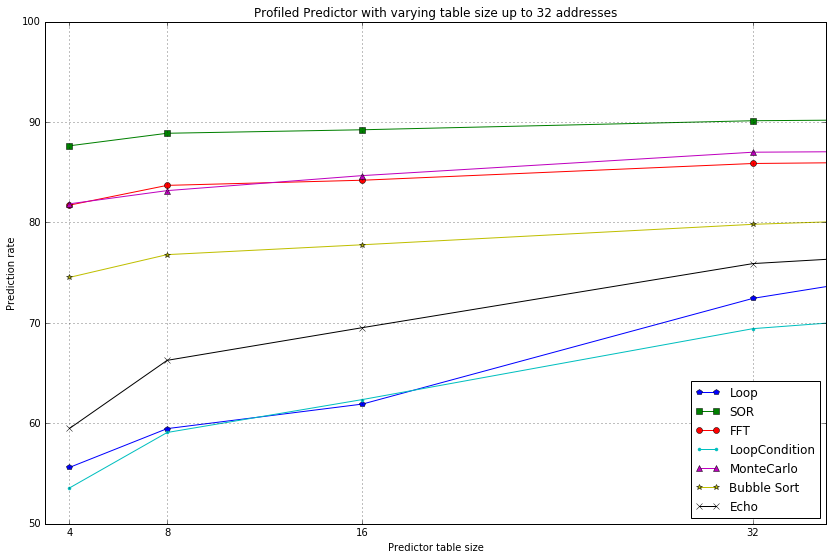

In [24]:
pp_graph = plot_graph("Profiled Predictor with varying table size", 
                      [data for _, data in gshare_experiment_twobits_history.items()])
pp_graph.plot()
plt.show()
pp_graph = plot_graph("Profiled Predictor with varying table size up to 32 addresses", 
                      [data for _, data in gshare_experiment_twobits_history.items()],
                      xticks=[2,4,8,16,32])
pp_graph.plot()
plt.xlim(3, 35)
plt.show()

The graphs show that our profiled approach again exhibits the same kind of trend as other predictors we have analysed. Since the profiled approach uses the correlating predictor, we can also vary the number of history bits for the profiled approach and see the behaviour as that was where we had changes and variation between correlating and Gshare strategies.

In [25]:
def profiled_history_experiment(bits):
    experiment = new_benchmark_experiment()
    
    for i in range(1, 12):
        pp = ProfiledPredictor(bits, i)
        for k, v in experiment.items():
            v.data.append((i, pp.simulate(v.trace)))
            
    return experiment
            
pp_experiment_64_addresses = profiled_history_experiment(6) 
pp_experiment_512_addresses = profiled_history_experiment(9)
pp_experiment_1024_addresses = profiled_history_experiment(10)
pp_experiment_2048_addresses = profiled_history_experiment(11)

<function matplotlib.pyplot.show>

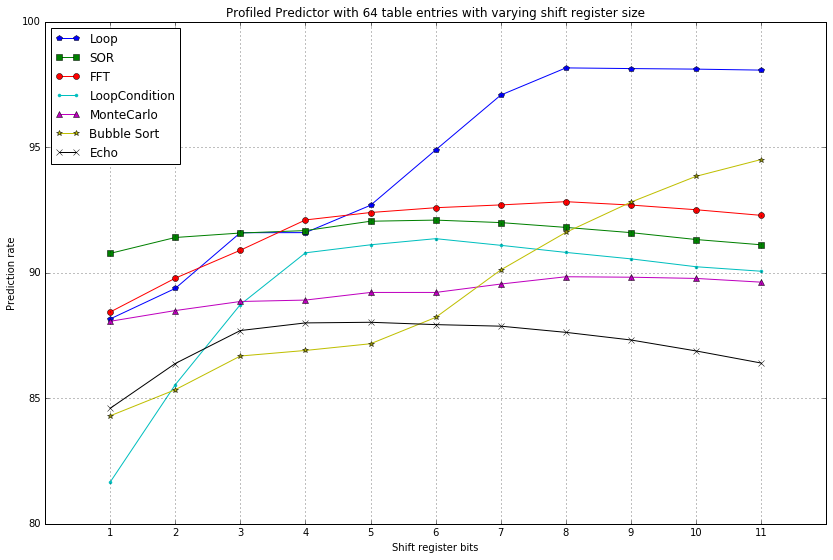

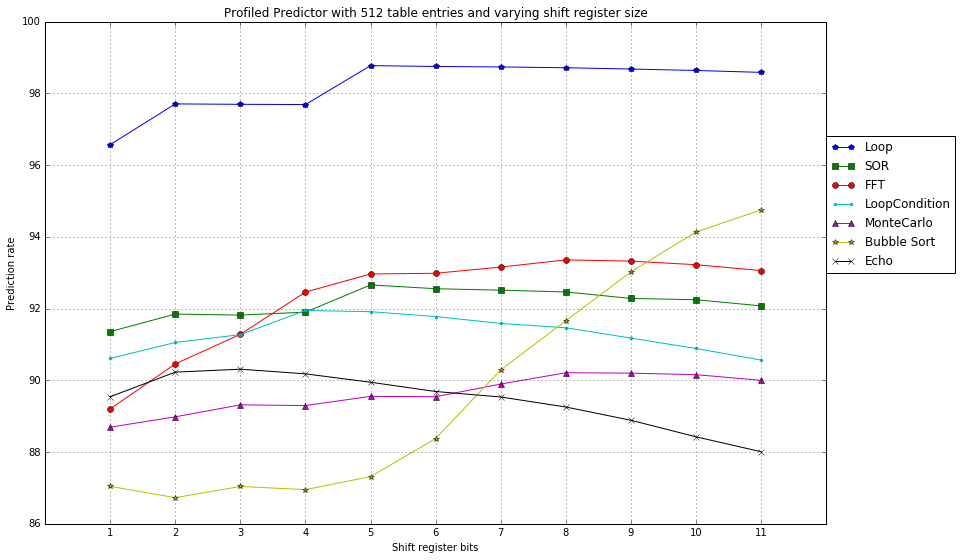

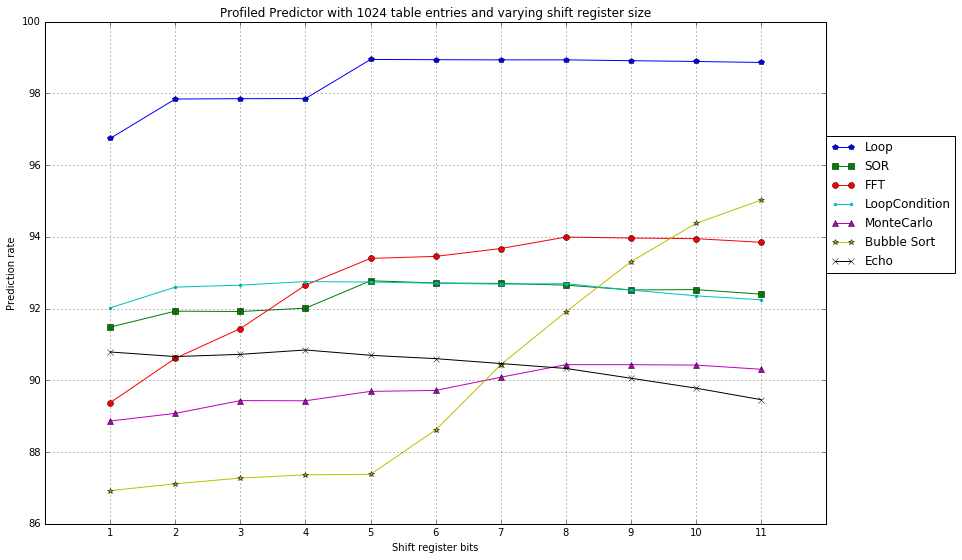

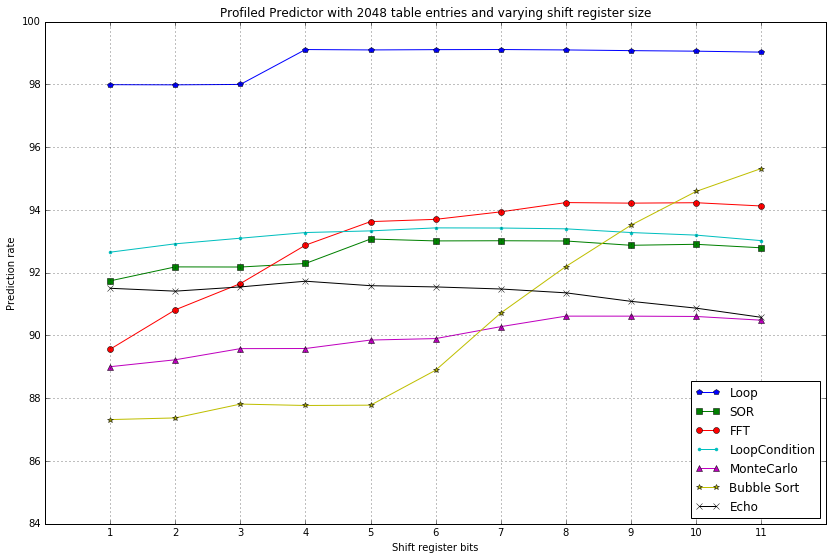

In [26]:
pp_64_addresses_graph = plot_graph("Profiled Predictor with 64 table entries with varying shift register size",
                                   [data for _, data in pp_experiment_64_addresses.items()],
                                   xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="best")
plt.xlim(0, 12)
pp_512_addresses_graph = plot_graph("Profiled Predictor with 512 table entries and varying shift register size", 
                                    [data for _, data in pp_experiment_512_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(1,0.5))
plt.xlim(0, 12)
pp_1024_addresses_graph = plot_graph("Profiled Predictor with 1024 table entries and varying shift register size", 
                                    [data for _, data in pp_experiment_1024_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc=(1,0.5))
plt.xlim(0, 12)
pp_2048_addresses_graph = plot_graph("Profiled Predictor with 2048 table entries and varying shift register size", 
                                    [data for _, data in pp_experiment_2048_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9,10,11])
plt.legend(loc="lower right")
plt.ylim(84, 100)
plt.xlim(0, 12)
pp_64_addresses_graph.plot()
pp_512_addresses_graph.plot()
pp_1024_addresses_graph.plot()
pp_2048_addresses_graph.plot()
plt.xlim(0, 12)
plt.show

One particular benchmark to notice for the profiled approach is `Bubble Sort`. With all other predictors, `Bubble Sort` has one of the lowest prediction rates at high table sizes. Even in the correlating predictor where the shift register bits also go up to 11 bits. Here after 6 bits of history, the profiled approach performance for `Bubble Sort` increases greatly until the prediction rate is greater than even FFT, which has previously always had high prediction rate as the register bits increase. The number of table addresses also does not affect this behaviour as we get the same shape from 64 entries as with 2048 entries in the table. 

This is unlikely to be a collision problem being relieved by the extra counters in the correlating predictor of the profiled approach. Other benchmarks do not have the same kind of pattern so it should be to do with the behaviour of `Bubble Sort` itself. It also seems unlikely to do with the classifications and use of different predictor strategies. This is because at a low number of history bits, the prediction rate for `Bubble Sort` is still the lowest of all the benchmarks. Changing the number of history bits does not change the effect of other classifications, only the branches classified in the middle class. The classification may be helping the performance by filtering out a large number of branches so the correlating predictor gets less collisions, but the percentage of branches classified to used the correlating predictor for `Bubble Sort` is comparable to other benchmarks. 

In [27]:
# Show percentages of branches classified as mixed classification
def get_percentage_mixed_class(trace):
    pp = ProfiledPredictor(10, 1)
    pp.simulate(trace)

    cps = 0
    for _, p in pp.table.items():
        if isinstance(p, CorrelatingPredictor):
            cps += 1

    return cps/float(len(pp.table))


In [28]:
get_percentage_mixed_class(trace_sort)

0.3891402714932127

In [29]:
get_percentage_mixed_class(trace_loop)

0.4041331802525832

In [30]:
get_percentage_mixed_class(trace_mc)

0.4671857619577308

In [31]:
get_percentage_mixed_class(trace_sor)

0.45755237045203967

In [32]:
get_percentage_mixed_class(trace_cond)

0.37942857142857145

Most likely there is a combinations of factors based on the behaviour of `Bubble Sort`, the classification and the number of history bits that lets the profiled approach perform so much better. The branches that were not classified out may have a strong correlation between previous and current branches that becomes detected with more history bits.

### Comparison of prediction strategies

The results for the correlating predictor are initially similar to those for the two-bit predictor and often slightly better. All benchmarks except for the `Loop` benchmark start with a higher prediction rate.

| Benchmark | Two-bit predictor with 2 table addresses | Correlating predictor with 2 table addresses |
|  ---------| ----- | --------- |
|  Echo   |   57.89%   | 67.53% |
| FFT | 82.66% | 85.02% |
| SOR | 87.79% | 89.17% |
| MonteCarlo | 82.03% | 82.95% |
| Loop | 57.95% | 53.00% |
| Conditional | 57.81% | 59.18% |
| Bubble Sort | 69.77% | 77.62% |

<center> Table comparing prediction rates of two-bit predictor and correlating predictor with 2 table addresses </center>

With the shift register and more saturating counters, the correlating predictor is able to overcome collisions better than the simple two bit predictor and therefore able to perform better at a lower number of table addresses. The trade-off here is the amount of memory the correlating predictor needs. In this case the shift register only has 2 bits so the trade-off may be worth it. For example for the `Echo` benchmark, the correlating predictor predicts 10% more branches correctly compared to the two bit predictor. 

Let's look at comparison of all prediction strategies on all the benchmarks. Predictor address table is at size 1024 and number of history bits kept at 2. The table size was chosen as all predictors had started to stagnate growth in prediction rates past this size and history bits kept at 2 as some benchmarks perform better with low histories.

In [33]:
key = "BubbleSort"

In [34]:
twobit_experiment[key].data[9][1]

87.32759273482546

In [35]:
cp_experiment_1024_addresses[key].data[1]

(2, 86.9265261085449)

In [36]:
gp_experiment_1024_addresses[key].data[1]

(2, 86.77075107365779)

In [37]:
pp_experiment_1024_addresses[key].data[1]

(2, 87.11583604677578)

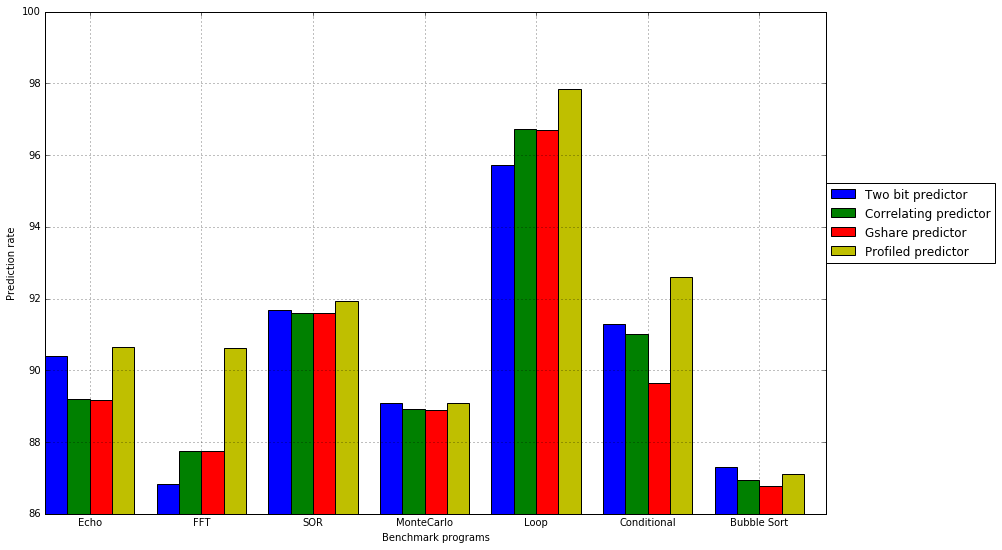

In [38]:
data_twobit = (90.40, 86.83, 91.68, 89.10, 95.73, 91.30, 87.31)
data_correlating = (89.21, 87.75, 91.60, 88.91, 96.72, 91.01, 86.93)
data_gshare = (89.18, 87.76, 91.59, 88.89, 96.71, 89.64, 86.77)
data_profile = (90.66, 90.61, 91.93, 89.08, 97.84, 92.60, 87.12)

g = plot_bargraph("Comparison of all predictor strategies for a table size of 1024 and 2 history bits.",
                  data_twobit, data_correlating, data_gshare, data_profile)

In the comparison, we can see that the performance of each prediction strategy varies with the benchmark being run. In some shorter traces like `Echo` and `Conditional`, the two bit strategy performs better than correlating and Gshare, likely due to the warming up required by correlating and Gshare which makes them perform worse on shorter traces. On a longer trace like `FFT`, the correlating and Gshare predictor perform better than two bit and are quite similar to each other. This shows us that although Gshare usually does not predict as well as correlating, it is very similar, and due to the memory requirements of the correlating strategy, Gshare is a good strategy to choose between the two. The only issue is that Gshare suffers from occasional lapses of performance when the history bits line up poorly with inner loops and the damage from collisions spread across the address space. This is partially remedied with increased table size.

However, the simple two bit predictor is still able to perform close to or better than the prediction rates of correlating and Gshare. Based on these results, it would usually be better to choose the two bit implementation, but the benchmarks do not represent all programs. It could be the case that more complicated or longer traces leads to the global history having a larger impact than local branch histories. In much of the literature on branch prediction, the Gshare scheme performs very well so further experimentation with more benchmarks is needed to draw a conclusion.

Finally, the profiled approach out performs every predictor strategy in almost all benchmarks. The graph above shows only 2 history bits used, but the profile approach gets significantly better for `Bubble Sort` on more history bits. By using different strategies for different branch behaviours, even a simple profiled strategy like the one implemented here can do better than two bit, correlating or Gshare alone. The issue with the profiled approach is the need for a profile of the code and afterwards to be able to tag branches to let the hardware know about the classifications. Furthermore, more hardware is needed because the profiled approach uses multiple prediction strategies rather than just one. This is the trade off for having higher prediction rates.

An interesting comparison to make is for `Loop` benchmark between the correlating predictor and Gshare predictor with varying shift register size.

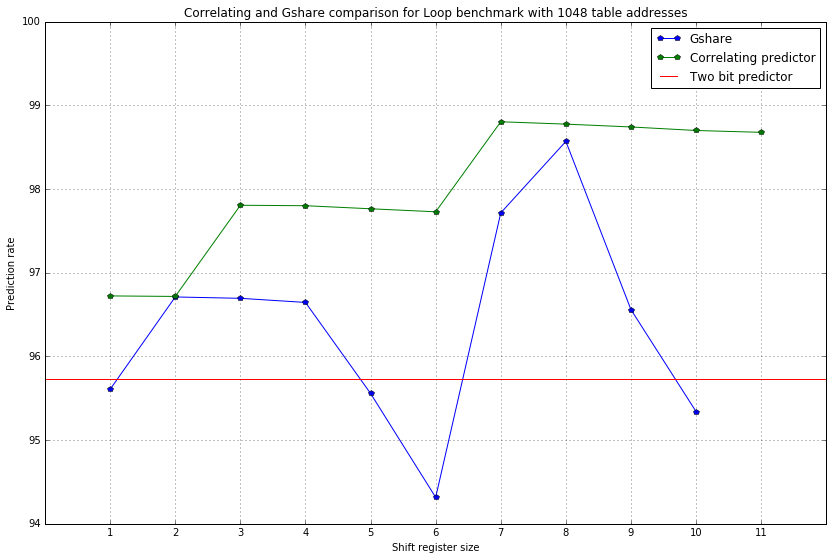

In [39]:
gshare_data = gp_experiment_1024_addresses["Loop"]
gshare_data.label = "Gshare"
correlating_data = cp_experiment_1024_addresses["Loop"]
correlating_data.label = "Correlating predictor"

cp_gshare_comparison_graph = plot_graph("Correlating and Gshare comparison for Loop benchmark with 1048 table addresses",
                                        [gshare_data, correlating_data],
                                        xlabel="Shift register size",
                                        xticks=[1,2,3,4,5,6,7,8,9,10,11])
cp_gshare_comparison_graph.plot([0,12],[95.73,95.73], label="Two bit predictor")
plt.legend()
cp_gshare_comparison_graph.plot()
plt.xlim(0, 12)
plt.show()

We can see from the comparison that the correlating predictor does not suffer from large hits to prediction rate due to collisions on mis-aligned histories. It is able to deal with these issues with its larger bank of saturating counters.

Gshare's performance is varied. On most occasions it does well and better than the two bit predictor, but on the cases where the mismatched histories and collisions cause the downwards spike in prediction rate, it performs worse than just the simple two bit predictor. It is also comparable to the correlating predictor, for example on 2 and 8 bits of history. As described before, this shows the importance of program behaviour on the performance of Gshare. The memory cost of the correlating predictor does not well justify one to use a correlating predictor over a two bit or Gshare strategy.

# Conclusion

In conclusion, for all predictor strategies, increasing table size leads to increased prediction rates with diminishing returns. It is not memory efficient to always just increase the address space as this will lead to little gain in performance, even if it is the case that having more space in the predictor address table increases prediction rates. 

The idea of correlating predictors and the Gshare strategy is to predict the direction of the current branch based on the direction of the previous branches. These strategies also improve with larger table sizes but their performance as the number of history bits increases is dependent on the behaviour of the program. As long as Gshare is not in its worst case where prediction rates drop from mis-alignment and collisions, it is close to the correlating predictor's performance such that it is more memory efficient for hardware to use Gshare rather than the correlating strategy.

However, in my results, both correlating and the Gshare strategy do not significantly over perform against a simple two bit predictor. In some cases, the two bit predictor performs even better than the history predictors. This may be due to the benchmarks not displaying enough behaviour that depends on past branches. `FFT` is an example where Gshare and correlating predictors perform better compared to the two bit predictor and their performance only increases with more history bits. Similarily, `Bubble Sort` has good performance with lots of history bits on the profiled approach, suggesting the correlating predictor and Gshare could normally perform better than the results suggest for other benchmarks.


# Further work

For further analysis of these prediction strategies, properties of branches could be recorded. Conditional and unconditional branches can then be compared on different strategies. Furthermore, more varied benchmarks could be used for analysis to clearly show the performance of the correlating predictor and Gshare doing well. 

# References

[1] Chang, Po-Yung et al. [*Branch Classification: A New Mechanism for Improving Branch Predictor Performance*](https://dl.acm.org/citation.cfm?id=192727). Proceedings of the 27th Annual International Symposium on Microarchitecture. ACM. 1994.

[2] Cheng, Chih-Cheng. [*The Schemes and Performances of Dynamic Branch Predictors*](http://bwrcs.eecs.berkeley.edu/Classes/CS252/Projects/Reports/terry_chen.pdf). CS252 Graduate Computer Architecture. 2000.

[3] Lee, Ben. [*Dynamic Branch Prediction*](http://web.engr.oregonstate.edu/~benl/Projects/branch_pred/). Oregon State University.

[4] Lee, Johnny K. F. and Smith, Alan J. [*Analysis of Branch Prediction Strategies and Branch Target Buffer Design.*](https://www2.eecs.berkeley.edu/Pubs/TechRpts/1983/CSD-83-121.pdf) University of California at Berkeley. 1983.
 
[5] McFarling, Scott. [*Combining Branch Predictors.*](http://www.hpl.hp.com/techreports/Compaq-DEC/WRL-TN-36.pdf). WRL-Technical Note TN-36. Jun 1993.

[6] Su, Zhendong and Zhou, Min. [*A Comparative Analysis of Branch Prediction Schemes*.](http://web.cs.ucdavis.edu/~su/Berkeley/cs252/project.html]) CS252 Graduate Computer Architecture Class Project. Computer Science Division, University of California at Berkeley. Dec 1995.
